In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
from collections import Counter

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Create datasets with different imbalance ratios
ratios = [0.5, 0.7, 0.9, 0.95, 0.99]
datasets = []

for ratio in ratios:
    X, y = make_classification(n_samples=10000, n_features=20, n_informative=10,
                              n_redundant=5, weights=[ratio], flip_y=0.1,
                              random_state=42)
    datasets.append((X, y, ratio))
    print(f"Ratio {ratio}: Class distribution {Counter(y)}")

Ratio 0.5: Class distribution Counter({np.int64(0): 5021, np.int64(1): 4979})
Ratio 0.7: Class distribution Counter({np.int64(0): 6826, np.int64(1): 3174})
Ratio 0.9: Class distribution Counter({np.int64(0): 8629, np.int64(1): 1371})
Ratio 0.95: Class distribution Counter({np.int64(0): 9074, np.int64(1): 926})
Ratio 0.99: Class distribution Counter({np.int64(0): 9431, np.int64(1): 569})


Ratio 0.50 - Brier: 0.1514, Log Loss: 0.4706
Ratio 0.70 - Brier: 0.1298, Log Loss: 0.4233
Ratio 0.90 - Brier: 0.0867, Log Loss: 0.3130
Ratio 0.95 - Brier: 0.0686, Log Loss: 0.2630
Ratio 0.99 - Brier: 0.0508, Log Loss: 0.2088


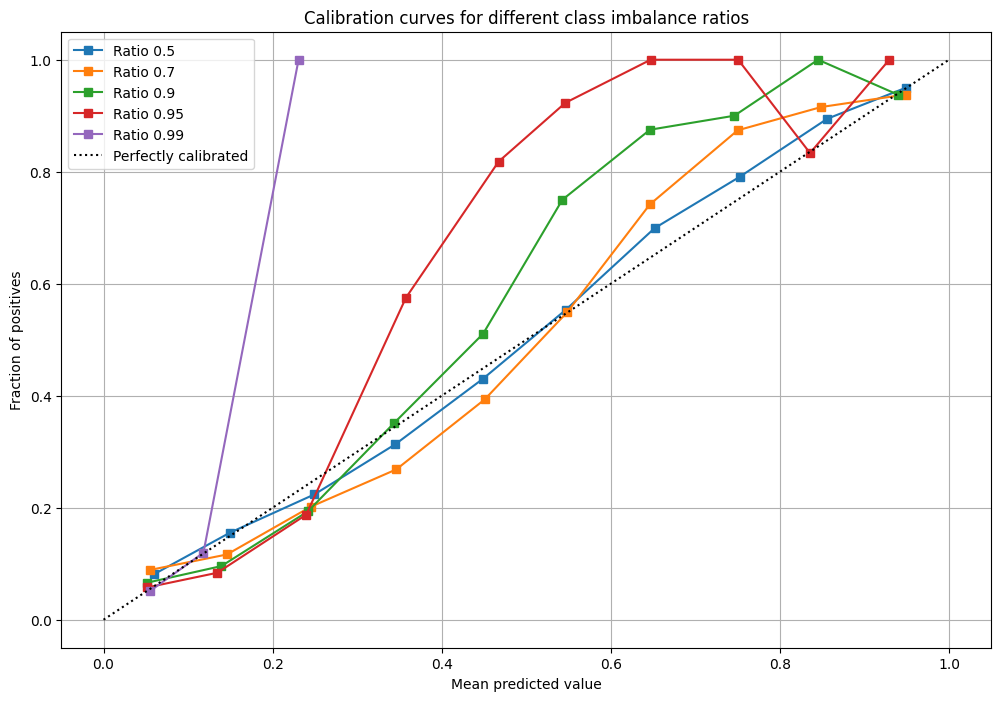

In [3]:
plt.figure(figsize=(12, 8))

for X, y, ratio in datasets:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train logistic regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Get predicted probabilities
    prob_pos = model.predict_proba(X_test)[:, 1]
    
    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    # Plot calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Ratio {ratio}")
    
    # Calculate evaluation metrics
    brier = brier_score_loss(y_test, prob_pos)
    logloss = log_loss(y_test, prob_pos)
    print(f"Ratio {ratio:.2f} - Brier: {brier:.4f}, Log Loss: {logloss:.4f}")

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves for different class imbalance ratios")
plt.legend()
plt.grid()
plt.show()

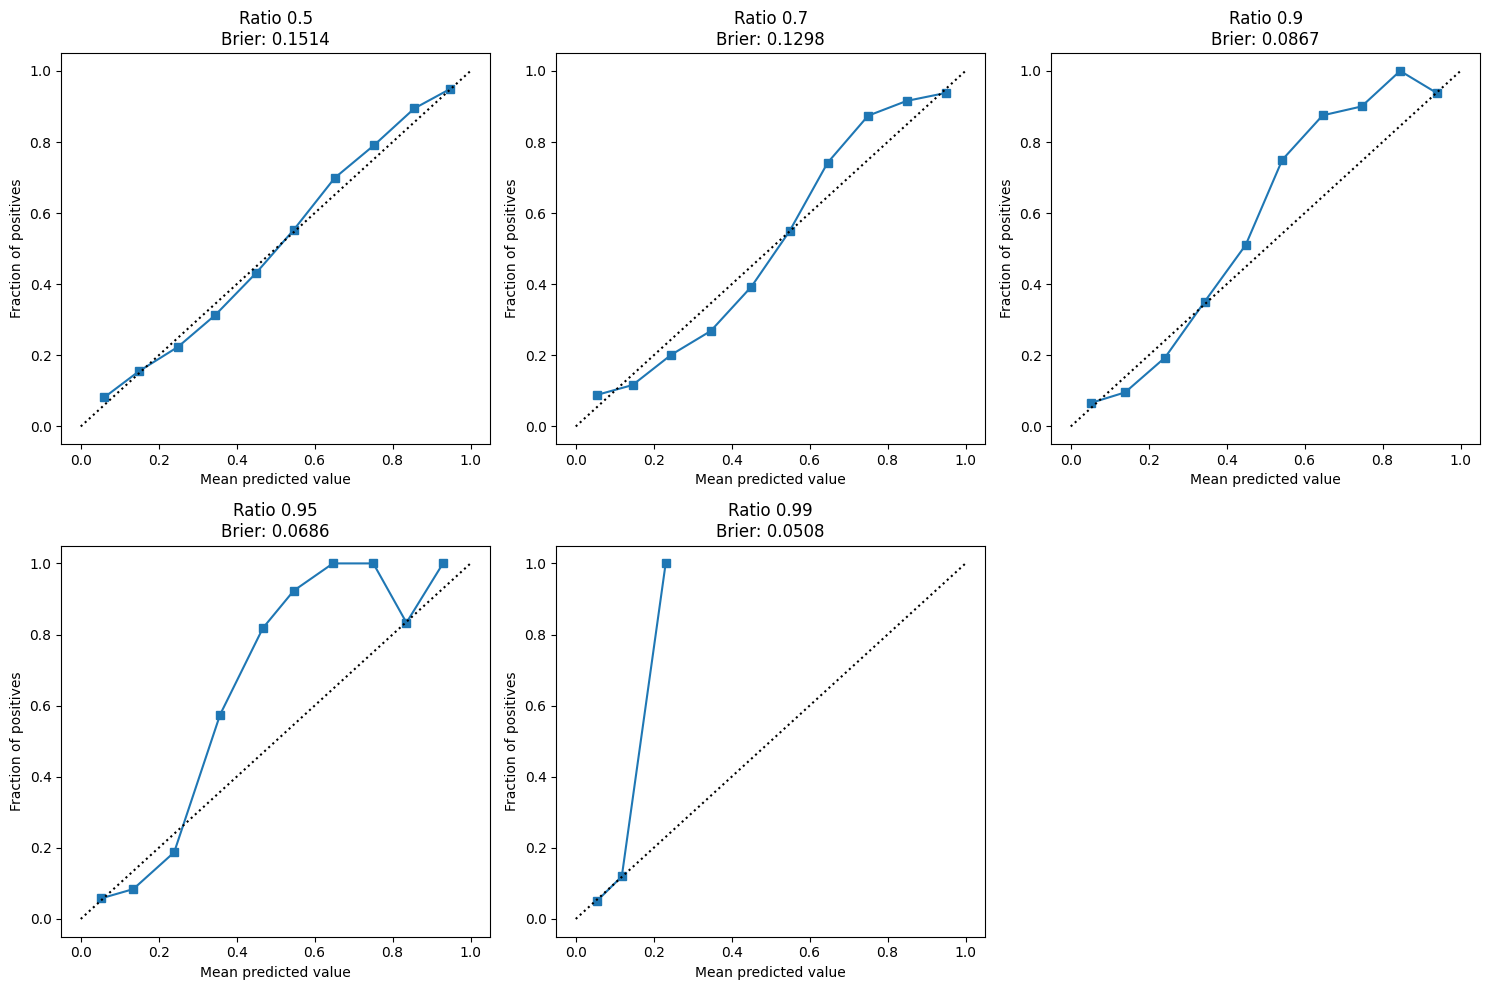

In [4]:
# Create separate reliability diagrams for each ratio
plt.figure(figsize=(15, 10))

for i, (X, y, ratio) in enumerate(datasets):
    plt.subplot(2, 3, i+1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    prob_pos = model.predict_proba(X_test)[:, 1]
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "k:")
    plt.title(f"Ratio {ratio}\nBrier: {brier_score_loss(y_test, prob_pos):.4f}")
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import imageio

# Set random seed for reproducibility
np.random.seed(42)

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))
plt.close()  # Prevent double display in notebook

# Function to update the plot for each frame
def update(ratio):
    ax.clear()
    
    # Generate data with current ratio
    X, y = make_classification(n_samples=20000, n_features=20, n_informative=10,
                              n_redundant=5, weights=[ratio], flip_y=0.1,
                              random_state=42)
    
    # Split and train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LogisticRegression(max_iter=100)
    model.fit(X_train, y_train)
    prob_pos = model.predict_proba(X_test)[:, 1]
    
    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    # Plot
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'Ratio {ratio:.2f}')
    ax.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
    ax.set_xlabel("Mean predicted value")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(f"Calibration Curve (Class Ratio = {ratio:.2f})")
    ax.legend(loc="lower right")
    ax.grid()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Calculate and display metrics
    brier = brier_score_loss(y_test, prob_pos)
    logloss = log_loss(y_test, prob_pos)
    ax.text(0.05, 0.85, f"Brier Score: {brier:.4f}\nLog Loss: {logloss:.4f}", 
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    return ax

# Generate frames for animation
ratios = np.arange(0.5, 0.96, 0.01)
frames = []
for ratio in ratios:
    fig, ax = plt.subplots(figsize=(8, 6))
    update(ratio)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)

# Save as GIF
imageio.mimsave('calibration_animation.gif', frames, fps=2, loop=0)

# Display in notebook
HTML('<img src="calibration_animation.gif">')

/tmp/ipykernel_21578/792384180.py:62: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_21578/792384180.py:62: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_21578/792384180.py:62: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykernel_21578/792384180.py:62: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
/tmp/ipykern

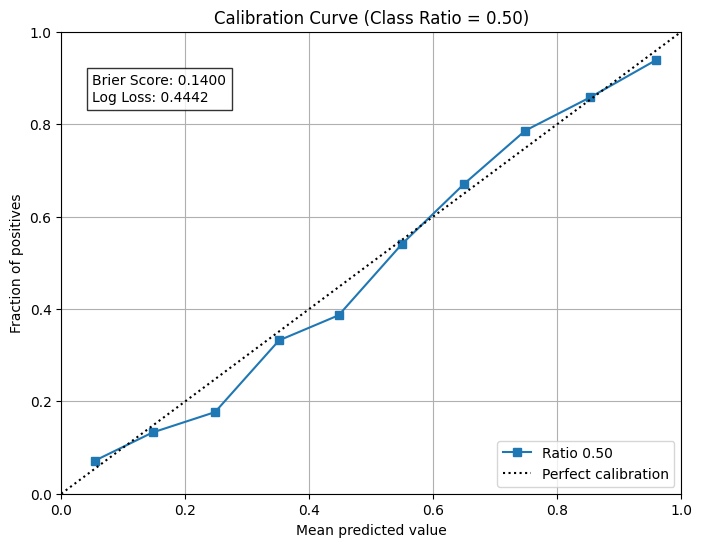

In [12]:
# Alternative version using FuncAnimation (works in some environments)
fig, ax = plt.subplots(figsize=(8, 6))

def animate(ratio):
    ax.clear()
    return update(ratio)

ani = FuncAnimation(fig, animate, frames=np.arange(0.5, 0.99, 0.005), interval=100)
HTML(ani.to_jshtml())